Expecting Training data in: C:\PBA\ML\Excercises\Week22-ExamProject\dataset\training_set\training_set
Expecting Test data in: C:\PBA\ML\Excercises\Week22-ExamProject\dataset\test_set\test_set

Creating training dataset...
Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Creating validation dataset...
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Class names found: ['cats', 'dogs']
Labels will be 0 for 'cats' and 1 for 'dogs'


C:\PBA\ML\Excercises\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.5142 - loss: 0.7072 - val_accuracy: 0.4191 - val_loss: 0.7340
Epoch 2/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.6556 - loss: 0.6264 - val_accuracy: 0.8164 - val_loss: 0.4181
Epoch 3/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.7107 - loss: 0.5715 - val_accuracy: 0.7364 - val_loss: 0.5191
Epoch 4/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - accuracy: 0.7497 - loss: 0.5121 - val_accuracy: 0.8014 - val_loss: 0.4339
Epoch 5/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.7830 - loss: 0.4515 - val_accuracy: 0.9332 - val_loss: 0.1951
Epoch 6/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.8077 - loss: 0.4132 - val_accuracy: 0.8770 - val_loss: 0.2941
Epoch 7/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.8501 - loss: 0.3549 - val_accuracy: 0.8601 - val_loss: 0.3613
Epoch 8/17
201/201 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step 

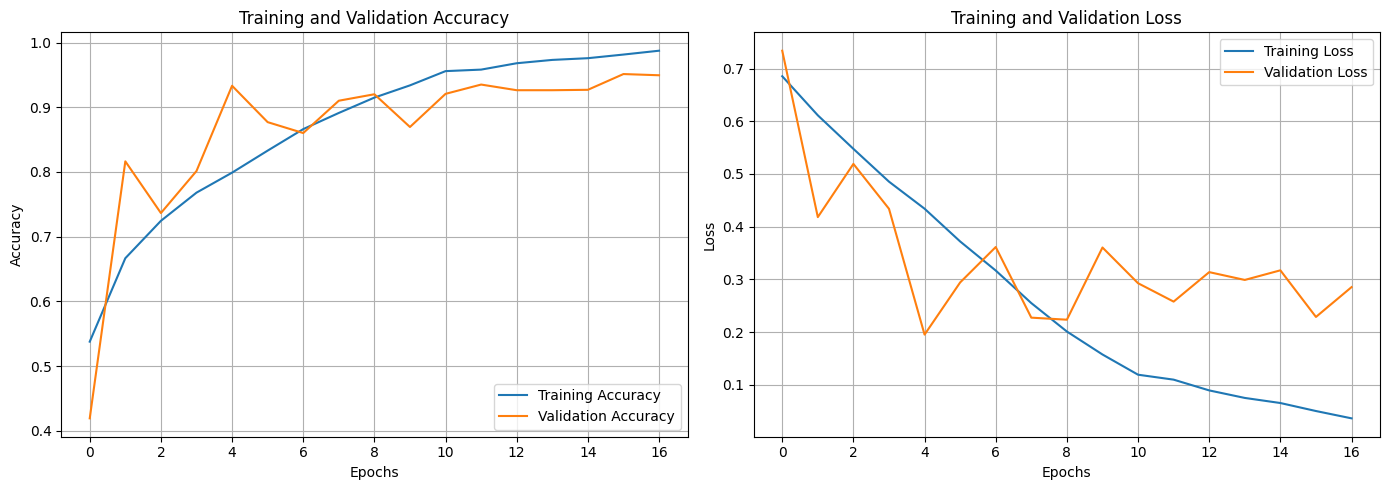


Script finished.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

base_project_dir = os.getcwd()
dataset_root_folder = os.path.join(base_project_dir, 'dataset')

# Define the direct paths to the training and test image folders
train_dir = os.path.join(dataset_root_folder, 'training_set', 'training_set')
test_dir = os.path.join(dataset_root_folder, 'test_set', 'test_set')

print(f"Expecting Training data in: {train_dir}")
print(f"Expecting Test data in: {test_dir}")

# Basic check if the primary dataset folder exists
if not os.path.exists(dataset_root_folder):
    print(f"Error: The 'dataset' folder was not found at {dataset_root_folder}")
    print("Please create it and ensure your data is extracted inside it according to the specified structure.")
    exit()

# Model and Training Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 17

# --- Create Datasets ---
print("\nCreating training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

print("Creating validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

class_names = train_dataset.class_names
print(f"Class names found: {class_names}")
if len(class_names) == 2:
    print(f"Labels will be 0 for '{class_names[0]}' and 1 for '{class_names[1]}'")
else:
    print(f"Warning: Expected 2 classes for binary classification, but found {len(class_names)}: {class_names}")
    print("The model is configured for binary classification. Please check your dataset structure in:")
    print(f"- Training: {train_dir}")
    print(f"- Test: {test_dir}")


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Define the Model
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# --- Compile the Model ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the Model
print("\nStarting model training...")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)
print("Training finished.")

# Evaluate on the Test Set
print("\nCreating test dataset ...")
test_images_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_images_dataset = test_images_dataset.prefetch(buffer_size=AUTOTUNE)

print("\nEvaluating on the dedicated test set:")
loss, accuracy = model.evaluate(test_images_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Save the Model
model_save_path = 'cat_dog_classifier.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Show Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_hist = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_hist, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinished.")

Model 'cat_dog_classifier_local_simplified.keras' loaded successfully.
Using class names for prediction: ['cats', 'dogs']
This means: Class 0 is 'cats', Class 1 is 'dogs'

--- Looking for images in: C:\PBA\ML\Excercises\Week22-ExamProject\images_to_predict ---
Found 2 image(s) to predict.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


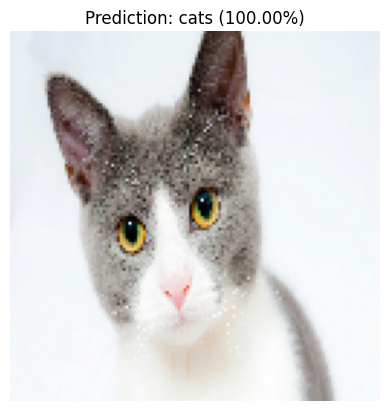

Image: cat1.jpg
Raw prediction score (prob of being 'dogs'): 0.0000
This image is predicted as: cats with 100.00% confidence.
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


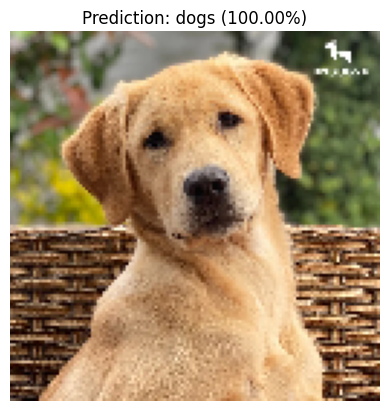

Image: dog3.jpg
Raw prediction score (prob of being 'dogs'): 1.0000
This image is predicted as: dogs with 100.00% confidence.
------------------------------

Prediction script finished.


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob # To find image files

# --- 1. Load the Trained Model ---
MODEL_NAME = 'cat_dog_classifier.keras'
try:
    model = tf.keras.models.load_model(MODEL_NAME)
    print(f"Model '{MODEL_NAME}' loaded successfully.")
except Exception as e:
    print(f"Error loading model '{MODEL_NAME}': {e}")
    exit()

# Image Parameters and Class Names
IMG_HEIGHT = 128
IMG_WIDTH = 128

class_names_pred = ['cats', 'dogs']
print(f"Using class names for prediction: {class_names_pred}")
print(f"This means: Class 0 is '{class_names_pred[0]}', Class 1 is '{class_names_pred[1]}'")

# Prediction Function
# score < 0.5 means the model predicts class 0
# score >= 0.5 means the model predicts class 1
def predict_image(image_path, model_to_use, class_labels):
    try:
        img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_to_use.predict(img_array)
    score = predictions[0][0]

    plt.imshow(img)
    plt.axis('off')

    if score < 0.5: # More likely to be class 0
        predicted_class_name = class_labels[0]
        confidence = 1 - score
    else: # More likely to be class 1
        predicted_class_name = class_labels[1]
        confidence = score

    plt.title(f"Prediction: {predicted_class_name} ({confidence*100:.2f}%)")
    plt.show()

    print(f"Image: {os.path.basename(image_path)}")
    print(f"Raw prediction score (prob of being '{class_labels[1]}'): {score:.4f}")
    print(f"This image is predicted as: {predicted_class_name} with {confidence*100:.2f}% confidence.")
    print("-" * 30)


prediction_folder_path = os.path.join(os.getcwd(), 'predict-images')

if not os.path.exists(prediction_folder_path):
    print(f"\nFolder '{prediction_folder_path}' not found.")
    print("Please create it and add images (.jpg, .jpeg, .png) you want to predict.")
else:
    print(f"\n--- Looking for images in: {prediction_folder_path} ---")
    # Supported image extensions
    image_extensions = ["*.jpg", "*.jpeg", "*.png"]
    image_files_to_predict = []
    for ext in image_extensions:
        image_files_to_predict.extend(glob.glob(os.path.join(prediction_folder_path, ext)))

    if not image_files_to_predict:
        print(f"No images found in '{prediction_folder_path}'.")
        print("Please add images (.jpg, .jpeg, .png) to this folder.")
    else:
        print(f"Found {len(image_files_to_predict)} image(s) to predict.")
        for img_file_path in image_files_to_predict:
            predict_image(img_file_path, model, class_names_pred)

print("\nPrediction script finished.")